In [1]:
# Set up
%pylab inline

# Allow us to edit fonts in Illustrator
import matplotlib
matplotlib.rcParams['ps.useafm'] = True
matplotlib.rcParams['pdf.use14corefonts'] = True
matplotlib.rcParams['text.usetex'] = True

# Libraries
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import scipy.stats as ss
import seaborn.apionly as sns
from collections import defaultdict

ANNOTDIR = "/storage/mgymrek/gtex/annotations/"
FEATUREDIR = "/storage/szfeupe/Runs/650GTEx_estr/Analysis_by_Tissue/"
HTDIR = "/storage/mgymrek/gtex/tfbs/encodedata/"
BEDDIR = "/storage/mgymrek/gtex/annotations/encode/"
mergefile = '/storage/szfeupe/Runs/650GTEx_estr/Analysis_by_Tissue/Merged_Best_causality.Table'
REGRSSION = '/storage/szfeupe/Runs/650GTEx_estr/Analysis_by_Tissue/LR_SummaryTest_Table.tsv'
SCORETYPE = ""
MINDIST = 1500 # For TSS
MINQ = 0.1 # FDR threshold. Ignored since overlap with Estrs later

# LIst of features to intersect with
FEATURES = {
    "3utr": os.path.join(ANNOTDIR, "3utr.bed"),
    "5utr": os.path.join(ANNOTDIR, "5utr.bed"),
    "coding": os.path.join(ANNOTDIR, "coding.bed"),
    "introns": os.path.join(ANNOTDIR, "introns.bed"),
    "H3K27ac": os.path.join(HTDIR, "H3K27ac_GM12878.bed.gz"),
    "H3K4me1": os.path.join(HTDIR, "H3K4me1_GM12878.bed.gz"),
    "H3K4me2": os.path.join(HTDIR, "H3K4me2_GM12878.bed.gz"),
    "H3K4me3": os.path.join(HTDIR, "H3K4me3_GM12878.bed.gz"),
    "H3K27me3": os.path.join(HTDIR, "H3K27me3_GM12878.bed.gz"),
    "H3K36me3": os.path.join(HTDIR, "H3K36me3_GM12878.bed.gz"),
}

percentiles = [0, 50] + list(np.arange(60, 101, 10))

Populating the interactive namespace from numpy and matplotlib


In [2]:
data = pd.read_csv(os.path.join(FEATUREDIR, "GTEx_merged_causality_tsstes%s.tab"%SCORETYPE), sep="\t")
Merge = pd.read_csv(mergefile, sep='\t')
data = pd.merge(data, Merge[['gene', 'chrom','best.str.start','top.variant']], on=['gene', 'chrom','best.str.start'])
data['str.start']=data['best.str.start']
GG   = pd.read_csv(REGRSSION, sep='\t')
data1 = pd.merge(data, GG[['chrom','str.start', 'gene','str.end','motif','E.tissues']], on=['chrom', 'str.start','gene' ] )

In [3]:
data1[['chrom','str.start','str.end','gene']].to_csv('reg.bed', sep='\t',index=None, header=None)
for key in FEATURES.keys():
    bedfile = FEATURES[key]
    annot = pd.read_csv(bedfile, sep="\t", header=None, skiprows=1)
    annot[[0,1,2]].to_csv('facts.bed', sep='\t',index=None, header=None)
    cmd = "bedtools intersect -a reg.bed -b facts.bed >Intersect.bed"
    returned_value = os.system(cmd)
    Inter = pd.read_csv('Intersect.bed', sep='\t', header=None)
    Feature_strs = list(set(list(Inter[3])))
    data1[key] = np.where(data1['gene'].isin(Feature_strs), 1, 0)

data1["tss"] = (data1["dist.to.tss"].apply(abs)<=MINDIST).apply(int)
keys = sorted(list(FEATURES.keys()) + ["tss"])

In [23]:
bins = np.percentile(data[data["best.q"]<=MINQ]["best.score"], q = percentiles)
data = data1[data1["best.score"] >= 0]
Xe = []
Xc = []
Xce = []
Pe = []
Pc = []
Pec = []

Table={}
Table['Features']=["pvalue _allestrs","oddsratio_allestrs","pvalue_causalestrs","oddsratio_causalestrs","pvalue.causal.strs (vs All)","oddsratio.causal.strs (vs all)","pvalue.causal.estrs (vs All)","oddsratio.causal.estrs (vs all)"]


lb = bins[len(bins)-3] #change this for the top bin
ub = bins[len(bins)-1] 
D = data[(data["best.score"]>lb) & (data["best.score"]<= ub) & (data["best.q"]<=MINQ)]
EE = D.loc[D['E.tissues']>=1]
causal = [i for i in list(D['top.variant']) if 'STR_' in i]
CAUS  = D.loc[D['top.variant'].isin(causal)]
CAUSe = CAUS.loc[CAUS['E.tissues']>=1]
C  = CAUS.shape[0]
Ce = CAUSe.shape[0]
E  = EE.loc[EE[key]>0].shape[0]


for key in keys:
    allfeature = D.loc[D[key]>0]
    CEF = allfeature.loc[allfeature['gene'].isin(list(CAUSe['gene']))].shape[0]
    CF  = allfeature.loc[allfeature['top.variant'].isin(causal)].shape[0]
    EF  = allfeature.loc[allfeature['E.tissues']>=1].shape[0]
    
    #cont. tables CTT
    CTTc = [[CEF , Ce-CEF],[CF - CEF, (CAUS.shape[0]-CF)- (Ce-CEF)]]
    CTTe = [[CEF , Ce-CEF],[EF - CEF, (EE.shape[0] - Ce ) - (EF-CEF)]]
    non_feat = D.shape[0] - allfeature.shape[0]
    CTTc1= [[CF , C-CF],[allfeature.shape[0]-CF , non_feat - (C-CF)]]
    CTTc2= [[CEF , Ce-CEF],[allfeature.shape[0]-CEF , non_feat - (Ce-CEF)]]

    #
    orc, pvc = ss.fisher_exact(CTTc)
    ore, pve = ss.fisher_exact(CTTe)
    or1c, pvec1 = ss.fisher_exact(CTTc1)
    or2c, pvec2 = ss.fisher_exact(CTTc2)
    
    #
    Table[key] = [pve, ore,pvc,orc,pvec1,or1c, pvec2, or2c]
    Pe.append(pve)
    Xe.append(np.log2(ore)) #estrs
    Pc.append(pvc)
    Xc.append(np.log2(orc)) #causal-estrs in estrs
    Pec.append(pvec)
    Xce.append(np.log2(or1c))#Causal estrs in all

T = pd.DataFrame(Table)   
T.index=T['Features']
del T['Features']
Marks = ['**' if v < 0.05 else ' ' if v <= 0.1 else '' for v in Pc]
T

/usr/lib/python3.4/site-packages/ipykernel/__main__.py:50: RuntimeWarning: divide by zero encountered in log2


,3utr,5utr,H3K27ac,H3K27me3,H3K36me3,H3K4me1,H3K4me2,H3K4me3,coding,introns,tss
Features,,,,,,,,,,,
pvalue _allestrs,1.000000,1.000000,1.000000,1.000000,0.335292,0.597343,1.000000,1.000000,1.000000,0.484693,0.267991
oddsratio_allestrs,inf,0.863309,1.015267,NaN,0.279720,inf,0.904762,0.960000,inf,1.509804,0.490385
pvalue_causalestrs,0.574146,0.033690,0.015416,1.000000,1.000000,0.271737,0.033898,0.001110,1.000000,0.693927,0.003183
oddsratio_causalestrs,0.580173,3.949640,2.717557,0.000000,0.725275,1.826087,2.080952,3.128889,1.277778,0.911406,3.442308
pvalue.causal.strs (vs All),0.240403,0.649095,0.017085,1.000000,0.019930,0.725364,0.273092,0.248253,0.408366,0.452048,0.170649
oddsratio.causal.strs (vs all),inf,0.693069,0.356468,inf,0.238340,0.785141,0.653928,0.637317,0.416016,1.210300,0.513759
pvalue.causal.estrs (vs All),0.771735,0.081764,0.081107,1.000000,0.534514,0.293692,0.064797,0.003858,1.000000,0.774069,0.012351
oddsratio.causal.estrs (vs all),0.697183,3.136691,1.861323,0.000000,0.501166,1.673913,1.809524,2.560000,1.016204,0.944411,2.568826


In [24]:
bins

array([2.864670e-31, 3.636100e-02, 4.770020e-02, 6.618222e-02,
       9.671876e-02, 1.656880e-01, 9.999970e-01])

In [25]:
lb

0.09671875999999999

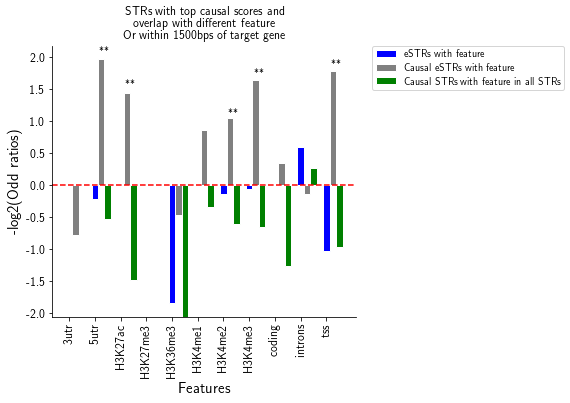

In [26]:
fig = plt.figure()
fig.set_size_inches((12, 5))
#COL = ["green","red","black",'m','maroon', 'navy','lightblue', 'pink', 'mediumpurple', 'orange','yellow',"blue","gray"]
Marks = ['**' if v < 0.05 else ' ' if v <= 0.1 else '' for v in Pc]
ax = fig.add_subplot(121)
i = 1
w=0.25
xvals = np.array(range(len(keys)))
Xc =[0.00 if (i==-inf or i==inf )else i for i in Xc]
Xc1 =[0.00 if (i==-inf or i==inf )else i for i in Xce]
Xe =[0.00 if (i==-inf or i==inf )else i for i in Xe]
bars1 = ax.bar(xvals, Xe, color="blue", edgecolor="white", width=w, label="eSTRs with feature")
bars2 = ax.bar(xvals+w, Xc, color="gray", edgecolor="white", width=w, label="Causal eSTRs with feature")
bars3 = ax.bar(xvals+2*w, Xc1, color="green", edgecolor="white", width=w, label="Causal STRs with feature in all STRs")
ax.set_xticks(xvals)
ax.set_xlabel("Features", size=15)
ax.set_ylabel("-log2(Odd ratios)", size=15)
ax.set_xticklabels(keys, size=12, rotation=90)
ax.set_yticklabels(ax.get_yticks(), size=12)
ax.axhline(y = 0.0, linestyle="dashed", color="red")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('    ')
for i in range(len(keys)):
    height = max([bars1[i].get_height(), bars2[i].get_height(), bars3[i].get_height()])
    label = Marks[i]
    ax.text(bars2[i].get_x() + bars2[i].get_width()/2.+w/2, 1.05*height, label, ha="center", va="bottom")
    i+=1
plt.title('STRs with top causal scores and \noverlap with different feature \nOr within 1500bps of target gene')
plt.show()


In [27]:
len(causal)

515